In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [30]:
# Load data from CSV.  Keep only the columns named "DATE" and "NAV"
FILENAME = "KKP-ACT-FIXED.csv"
# FILENAME = "BFIXED-20250912.csv"

# How many days of data to use?
NUM_DAYS = 180

df = pd.read_csv(FILENAME, usecols=["DATE","NAV"], parse_dates=["DATE"])
# Remove unused columns is not needed. Use 'usecols=' instead.
# df = df.drop(columns=["THAIDATE","Month"]).rename(columns={"DATE": "Date"})

# Pandas recommends avoiding sort with inplace=True due to possibly unexpected behavior
df = df.sort_values("DATE", ascending=True).reset_index(drop=True)

# Ensure Date is datetime and set as index
df = df.set_index("DATE")

# Use only recent data
df = df.tail(NUM_DAYS)

df.tail(10)


,NAV
DATE,
2025-09-01,12.2974
2025-09-02,12.2987
2025-09-03,12.2999
2025-09-04,12.3047
2025-09-05,12.3086
2025-09-08,12.3125
2025-09-09,12.3168
2025-09-10,12.3136
2025-09-11,12.3128


In [31]:
# Compute the relative price differences including effect of time (number of days between rows).
# days = df["DATE"].diff().dt.days
# If the "Date" is the index, then do this instead:
days = df.index.to_series().diff().dt.days

# Window size for moving averages
window_size = 5

# diff() gives absolute diff, pct_change() is relative change (x(t)-x(t-1))/x(t-1)
df["NAV_DIF"] = df["NAV"].diff() / days
df["NAV_DIF_PCT"] = df["NAV"].pct_change() / days * 100

# N-day moving average of price based on number of elapsed calendar days
window = f"{window_size}D"  # "5D"
df["NAV_MA"] = df["NAV"].rolling(window=window_size).mean()

# statistical magnitude of NAV deviatiation from MA
df["Dev_%"] = (df["NAV"] - df["NAV_MA"]) / df["NAV_MA"] * 100

df.tail(10)

,NAV,NAV_DIF,NAV_DIF_PCT,NAV_MA,Dev_%
DATE,,,,,
2025-09-01,12.2974,0.001967,0.016000,12.29164,0.046861
2025-09-02,12.2987,0.001300,0.010571,12.29362,0.041322
2025-09-03,12.2999,0.001200,0.009757,12.29592,0.032368
2025-09-04,12.3047,0.004800,0.039025,12.29844,0.050901
2025-09-05,12.3086,0.003900,0.031695,12.30186,0.054788
2025-09-08,12.3125,0.001300,0.010562,12.30488,0.061927
2025-09-09,12.3168,0.004300,0.034924,12.30850,0.067433
2025-09-10,12.3136,-0.003200,-0.025981,12.31124,0.019169
2025-09-11,12.3128,-0.000800,-0.006497,12.31286,-0.000487


In [32]:
# Z-scores and Bollinger Bands using daily returns
# Same as above:
days = df.index.to_series().diff().dt.days
# For Logarithmic returns use:
# daily_return = np.log(df["NAV"] / df["NAV"].shift(1))
# For simple % differences use
# daily_return = (df["NAV"] / df["NAV"].shift(1) - 1) * 100
# This version accounts for number of elapsed calendar days between NAV data points
daily_return = df["NAV_DIF_PCT"]
# Window size (days) for rolling averages (or use same size as MA window)
window = f"{window_size}D"
rolling_mean = daily_return.rolling(window_size).mean()
rolling_std = daily_return.rolling(window_size).std()

df["Daily_return"] = daily_return
df["Return_Z_Score"] = (daily_return - rolling_mean) / rolling_std

df.tail(20)


,NAV,NAV_DIF,NAV_DIF_PCT,NAV_MA,Dev_%,Daily_return,Return_Z_Score
DATE,,,,,,,
2025-08-18,12.2839,0.001267,0.010315,12.27478,0.074299,0.010315,-0.333682
2025-08-19,12.2829,-0.001000,-0.008141,12.27934,0.028992,-0.008141,-0.699762
2025-08-20,12.2843,0.001400,0.011398,12.28238,0.015632,0.011398,-0.218996
2025-08-21,12.2832,-0.001100,-0.008955,12.28288,0.002605,-0.008955,-0.882813
2025-08-22,12.2828,-0.000400,-0.003256,12.28342,-0.005047,-0.003256,-0.355998
2025-08-25,12.2892,0.002133,0.017368,12.28448,0.038422,0.017368,1.308861
2025-08-26,12.2888,-0.000400,-0.003255,12.28566,0.025558,-0.003255,-0.530339
2025-08-27,12.2884,-0.000400,-0.003255,12.28648,0.015627,-0.003255,-0.293619
2025-08-28,12.2921,0.003700,0.030110,12.28826,0.031249,0.030110,1.460053


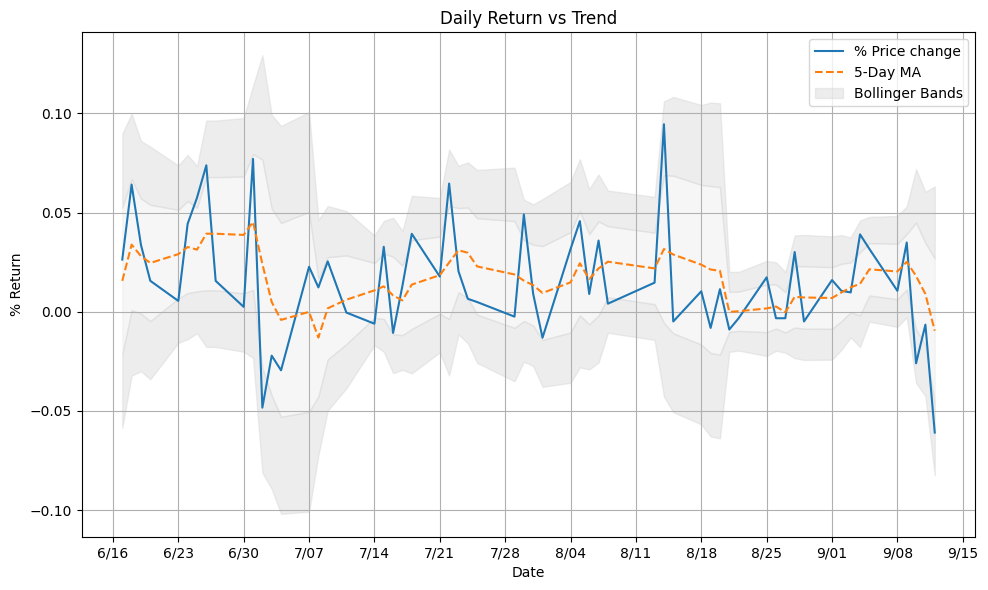

In [33]:
# Plot NAV, SMA, and Bollinger Bands
# Plot recent data instead of entire df
plot_days = 12 * 5

# Bollinger Bands of Daily Returns
df["Upper_1std"] = rolling_mean + 1 * rolling_std
df["Upper_2std"] = rolling_mean + 2 * rolling_std
df["Lower_1std"] = rolling_mean - 1 * rolling_std
df["Lower_2std"] = rolling_mean - 2 * rolling_std

import matplotlib.dates as mdates
# Locate x-ticks every 5 days
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()

recent = df.tail(plot_days)

plt.figure(figsize=(10,6))
# The df.index is Date, so plot df.index instead of df["Date"]
plt.plot(recent.index, recent["Daily_return"], label="% Price change")  # marker="o"
plt.plot(recent.index, rolling_mean.tail(plot_days), label=f"{window_size}-Day MA", linestyle="--")

# Separate Bollinger Bands into 1 and 2-stdev
fill_color = "lightgray"
plt.fill_between(recent.index, recent["Lower_2std"], recent["Lower_1std"],  color=fill_color, alpha=0.4,
                 label="Bollinger Bands")
plt.fill_between(recent.index, recent["Upper_2std"], recent["Upper_1std"],  color=fill_color, alpha=0.4)
# middle band
plt.fill_between(recent.index, recent["Lower_1std"], recent["Upper_1std"],  color=fill_color, alpha=0.2)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
plt.gca().xaxis.set_major_locator(xticks)
plt.title("Daily Return vs Trend")
plt.xlabel("Date")
plt.ylabel("% Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

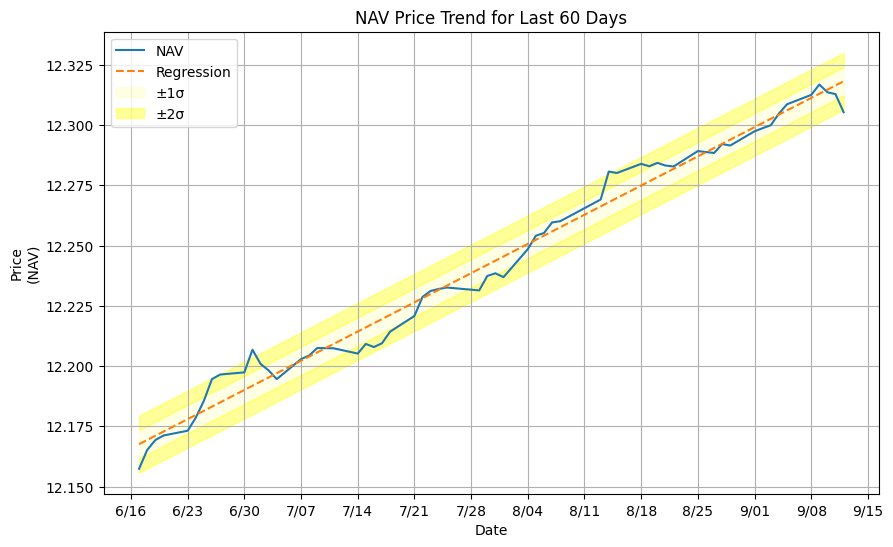

In [34]:
# Regression of NAV and regression trend line for last N days
N = 12 * 5
recent = df.tail(N).copy()
# Convert dates to integer number of days since beginning of the data
X = (recent.index - recent.index[0]).days.values.reshape(-1,1)
Y = recent["NAV"].values

model = LinearRegression().fit(X, Y)
trend = model.predict(X)

# For confidence bands
residuals = Y - trend
sigma = np.std(residuals)

plt.figure(figsize=(10,6))
plt.plot(recent.index, Y, label="NAV")  # marker="o"
plt.plot(recent.index, trend, linestyle="--", label="Regression")

# 1- and 2-stdev bands
fill_color = "yellow"
plt.fill_between(recent.index, trend - sigma, trend + sigma, color=fill_color, alpha=0.1, label="±1σ")
plt.fill_between(recent.index, trend - 2*sigma, trend - 1*sigma, color=fill_color, alpha=0.4, label="±2σ")
plt.fill_between(recent.index, trend + 2*sigma, trend + 1*sigma, color=fill_color, alpha=0.4)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
# Locate x-ticks every 5 days:
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(xticks)
plt.title(f"NAV Price Trend for Last {N} Days")
plt.xlabel("Date")
plt.ylabel("Price\n(NAV)")
plt.legend()
plt.grid(True)
plt.show()



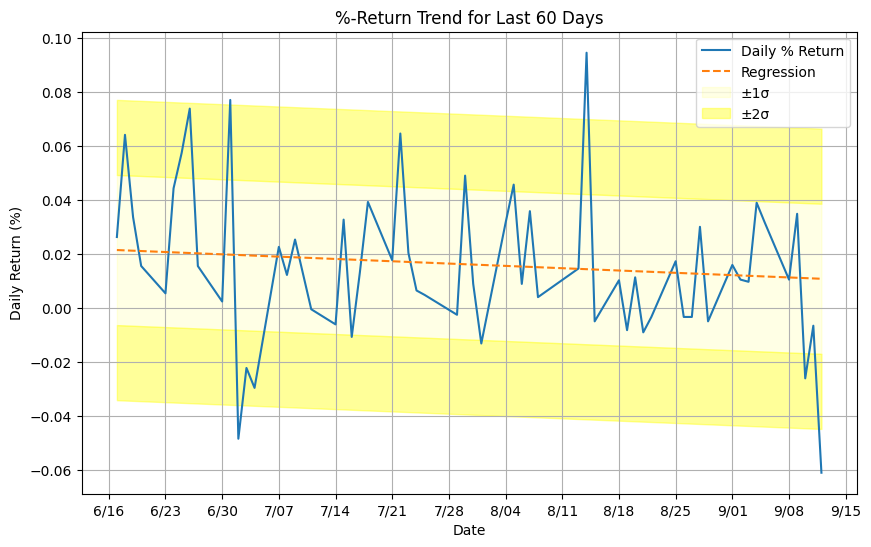

In [36]:
# Linear Regression using daily % return as Y variable
# Regression of NAV and regression trend line for last N days
N = 12 * 5
# N = NUM_DAYS - 2
recent = df.tail(N).copy()
# Convert dates to integer number of days since beginning of the data
X = (recent.index - recent.index[0]).days.values.reshape(-1,1)
Y = recent["NAV_DIF_PCT"].values

# regression but exclude M days on both ends
M = 2
model = LinearRegression().fit(X[M:-M], Y[M:-M]) if M > 0 else LinearRegression().fit(X, Y)
trend = model.predict(X)

# For confidence bands
residuals = Y - trend
sigma = np.std(residuals)

plt.figure(figsize=(10,6))
plt.plot(recent.index, Y, label="Daily % Return")  # marker="o"
plt.plot(recent.index, trend, linestyle="--", label="Regression")

# 1- and 2-stdev bands
fill_color = "yellow"
plt.fill_between(recent.index, trend - sigma, trend + sigma, color=fill_color, alpha=0.1, label="±1σ")
plt.fill_between(recent.index, trend - 2*sigma, trend - 1*sigma, color=fill_color, alpha=0.4, label="±2σ")
plt.fill_between(recent.index, trend + 2*sigma, trend + 1*sigma, color=fill_color, alpha=0.4)

# concise format for dates on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%-m/%d"))  # "m/dd" format
# Locate x-ticks every 5 days:
# xticks = mdates.DayLocator(interval=5)
# Locate x-ticks on Mondays
xticks = mdates.WeekdayLocator(byweekday=mdates.MO)
# Automatic tick locator
# xticks = mdates.AutoDateLocator()
plt.gca().xaxis.set_major_locator(xticks)
plt.title(f"%-Return Trend for Last {N} Days")
plt.xlabel("Date")
plt.ylabel("Daily Return (%)")
plt.legend()
plt.grid(True)
plt.show()